# Demo: Using a Google Earth engine


 This example serves as a demonstration on how to interact with Google Earth Engine (GEE) from within the MetObs-toolkit framework.

In [1]:
import metobs_toolkit

## GEE authentication

Before proceeding, make sure you have **set up a Google developers account and a GEE project**. See [Using Google Earth Engine](https://metobs-toolkit.readthedocs.io/en/latest/topics/gee_authentication.html#using-google-earth-engine) for a detailed description of this.

To test the GEE authentication we can use the ``metobs_toolkit.connect_to_gee`` method. If you authenticate using new credentials, make sure **NOT** to check the *read-only-scopes*. (See Extracting ERA5 data).

In [2]:
%%script true 

metobs_toolkit.connect_to_gee() #Uses a credetial file that is stored on your computer

If something is wrong with your credential (or it is the first time/ expiered credetials) you can force the creation of a new credential (file). You only need to run this if the `metobs_toolkit.connect_to_gee()` returned an error.

In [3]:
%%script true 

metobs_toolkit.connect_to_gee(
    force=True, #create new credentials
    auth_mode='notebook', # 'notebook', 'localhost', 'gcloud' (requires gcloud installed) or 'colab' (works only in colab)
)

For more details on authentication we refer to the `Using Google Earth Engine <../Using_gee.html>`_ page and the [authentication info page](https://developers.google.com/earth-engine/guides/auth) of GEE.

## GEE interaction from the MetObs-toolkit

There are two classes that facilitate the interaction with GEE and the metobs_toolkit:

 * ``GeeStaticDatasetManager``: This class handles GEE Datasets that do not have a time dimension (static).
 * ``GeeDynamicDatasetManager``: This class handles GEE Datasets that have a time dimension.

 Both classes holds all the information to extract data, at the location of your stations, 
 from the corresponding GEE dataset. For the ``GeeStaticDatasetManager`` the extracted data will update the metadata of the stations and the corresponding ``Station.site`` attribute will be update. Typical examples are the extraction of Local Climate Zones (LCZ), altitude and landcoverfractions. 

 When data is extracted using a ``GeeDynamicDatasetManager``, timeseries is typically extracted. These timeseries are stored in ``ModelTimeSeries``. Typical examples are the extraction of ERA5 equivalent timeseries for a sensor.


By default some a GEEDatasetManager is create for some popular datasets:

In [4]:
default_managers=metobs_toolkit.default_GEE_datasets
default_managers

{'LCZ': GeeStaticDatasetManager representation of LCZ ,
 'altitude': GeeStaticDatasetManager representation of altitude ,
 'worldcover': GeeStaticDatasetManager representation of worldcover ,
 'ERA5-land': GeeDynamicDatasetManager representation of ERA5-land }

We can see that by default there are 3 ``GeeStaticDatasetManagers`` (lcz, altitude and worldcover), and one ``GeeDynamicDatasetManager`` (ERA5-land).

Let's look at the local climate zones (LCZ) dataset manager as example:

In [5]:
default_managers['LCZ'].get_info()

GeeStaticDatasetManager representation of LCZ 
------ Details --------- 
 * name: LCZ
 * location: RUB/RUBCLIM/LCZ/global_lcz_map/latest
 * value_type: categorical
 * scale: 100
 * is_static: True
 * is_image: False
 * is_mosaic: True
 * credentials: Demuzere M.; Kittner J.; Martilli A.; Mills, G.; Moede, C.; Stewart, I.D.; van Vliet, J.; Bechtel, B. A global map of local climate zones to support earth system modelling and urban-scale environmental science. Earth System Science Data 2022, 14 Volume 8: 3835-3873. doi:10.5194/essd-14-3835-2022
 -- Band -- 
 LCZ_Filter 
 -- classification -- 
 {1: 'Compact highrise', 2: 'Compact midrise', 3: 'Compact lowrise', 4: 'Open highrise', 5: 'Open midrise', 6: 'Open lowrise', 7: 'Lightweight lowrise', 8: 'Large lowrise', 9: 'Sparsely built', 10: 'Heavy industry', 11: 'Dense Trees (LCZ A)', 12: 'Scattered Trees (LCZ B)', 13: 'Bush, scrub (LCZ C)', 14: 'Low plants (LCZ D)', 15: 'Bare rock or paved (LCZ E)', 16: 'Bare soil or sand (LCZ F)', 17: 'Wate

As you can see, the DatasetManager contains info on where this dataset is stored on GEE, some details on the dataset and some defenitions (color schemes, aggregation, label defenitions).

# Extracting data from GEE

As a demonstration we are going to extract data from GEE. When we use the MetObs-toolkit for it, it will **extract data from GEE only at the locations of the stations**. This extracted data is thus linked to a station (by location).

Some common pracktices are to get the LCZ, altitude and some landcover information of all the stations. We start by importin the demo data and extract these details from corresponding datasets on GEE.

In [6]:
#Import the demo dataset
dataset = metobs_toolkit.Dataset()
dataset.import_data_from_file(
    template_file=metobs_toolkit.demo_template,
    input_data_file=metobs_toolkit.demo_datafile,
    input_metadata_file=metobs_toolkit.demo_metadatafile,
)

Luchtdruk is present in the datafile, but not found in the template! This column will be ignored.
Neerslagintensiteit is present in the datafile, but not found in the template! This column will be ignored.
Neerslagsom is present in the datafile, but not found in the template! This column will be ignored.
Rukwind is present in the datafile, but not found in the template! This column will be ignored.
Luchtdruk_Zeeniveau is present in the datafile, but not found in the template! This column will be ignored.
Globe Temperatuur is present in the datafile, but not found in the template! This column will be ignored.
The following columns are present in the data file, but not in the template! They are skipped!
 ['Luchtdruk_Zeeniveau', 'Neerslagsom', 'Luchtdruk', 'Globe Temperatuur', 'Neerslagintensiteit', 'Rukwind']
The following columns are found in the metadata, but not in the template and are therefore ignored: 
['Network', 'sponsor', 'benaming', 'stad']


The current metdata is rather limited:

In [7]:
dataset.metadf.head(5)

,lat,lon,school,geometry
name,,,,
vlinder01,50.980438,3.815763,UGent,POINT (3.81576 50.98044)
vlinder02,51.022379,3.709695,UGent,POINT (3.7097 51.02238)
vlinder03,51.324583,4.952109,Heilig Graf,POINT (4.95211 51.32458)
vlinder04,51.335522,4.934732,Heilig Graf,POINT (4.93473 51.33552)
vlinder05,51.052655,3.675183,Sint-Barbara,POINT (3.67518 51.05266)


To extract geospatial information for your stations, the **lat** and **lon** (latitude and longitude)
of your stations must be present in the metadf. If so, then geospatial
information will be extracted from GEE at these locations.

### Extracting LCZ from GEE
To extract the Local Climate Zones (LCZs) of your stations:

In [8]:
LCZ_values = dataset.get_LCZ()

# The LCZs for all your stations are extracted
print(LCZ_values.head(5))

                          LCZ
name                         
vlinder01  Low plants (LCZ D)
vlinder02       Large lowrise
vlinder03        Open midrise
vlinder04      Sparsely built
vlinder05       Water (LCZ G)


The LCZ data is returned by the ``Dataset.get_lcz()`` method. In addition metadata (stored in the ``Station.site`` attribute) of your dataset is also updated.

In [9]:
dataset.metadf.head(5)

,lat,lon,LCZ,school,geometry
name,,,,,
vlinder01,50.980438,3.815763,Low plants (LCZ D),UGent,POINT (3.81576 50.98044)
vlinder02,51.022379,3.709695,Large lowrise,UGent,POINT (3.7097 51.02238)
vlinder03,51.324583,4.952109,Open midrise,Heilig Graf,POINT (4.95211 51.32458)
vlinder04,51.335522,4.934732,Sparsely built,Heilig Graf,POINT (4.93473 51.33552)
vlinder05,51.052655,3.675183,Water (LCZ G),Sint-Barbara,POINT (3.67518 51.05266)


*Note* All the methods in this demo that are applied on a ``Dataset`` can also be applied on a ``Station``

In [10]:
#demonstration an Station-level
your_station = dataset.get_station('vlinder21')
the_LCZ_of_your_statation = your_station.get_LCZ()

print("The LCZ of vlinder21 is: ", the_LCZ_of_your_statation)

#or instpect the site attribute of the station
your_station.site.get_info()

The LCZ of vlinder21 is:  Sparsely built
Site of vlinder21:
 -- metadata from file --
  * Coordinates (51.260389, 2.991917) (latitude, longitude)
  Extra metadata from the metadatafile:
    * school: Zeelyceum
 -- data extracted from GEE --
  * LCZ: Sparsely built
  * LCZ: Sparsely built



### Extracting alitutde from GEE

Similar as LCZ extraction we can get the altitude of the stations. 

In [11]:
#Get altitude
altitude_data = dataset.get_altitude()

#FYI, the details of the DEM dataset:
metobs_toolkit.default_GEE_datasets['altitude'].get_info()

#The metadata is updated (altitude in meters)
dataset.metadf.head(5)

GeeStaticDatasetManager representation of altitude 
------ Details --------- 
 * name: altitude
 * location: CGIAR/SRTM90_V4
 * value_type: numeric
 * scale: 100
 * is_static: True
 * is_image: True
 * is_mosaic: False
 * credentials: SRTM Digital Elevation Data Version 4
 -- Band -- 
 elevation 
 -- classification -- 
 {} 
 -- aggregation -- 
 {} 
 -- colors -- 
 {} 



,lat,lon,LCZ,altitude,school,geometry
name,,,,,,
vlinder01,50.980438,3.815763,Low plants (LCZ D),12,UGent,POINT (3.81576 50.98044)
vlinder02,51.022379,3.709695,Large lowrise,7,UGent,POINT (3.7097 51.02238)
vlinder03,51.324583,4.952109,Open midrise,30,Heilig Graf,POINT (4.95211 51.32458)
vlinder04,51.335522,4.934732,Sparsely built,25,Heilig Graf,POINT (4.93473 51.33552)
vlinder05,51.052655,3.675183,Water (LCZ G),0,Sint-Barbara,POINT (3.67518 51.05266)


### Extracting landcover buffer fractions

A more detailed description of the landcover/land use in the microenvironment can be extracted in the form of landcover fractions in a circular buffer for each station.

You can select to aggregate the landcover classes to water - pervious and impervious, or set aggregation to false to extract the landcover classes as present in the worldcover_10m dataset.

In [12]:
aggregated_landcover = dataset.get_landcover_fractions(
                                        buffers=[100, 250], # a list of buffer radii in meters
                                        aggregate=True #if True, aggregate landcover classes to the water, pervious and impervious.
                                        )

print(aggregated_landcover.head(5))

                            water  pervious  impervious
name      buffer_radius                                
vlinder01 100            0.000000  0.981781    0.018219
vlinder02 100            0.000000  0.428769    0.571231
vlinder03 100            0.000000  0.245454    0.754546
vlinder04 100            0.000000  0.979569    0.020431
vlinder05 100            0.446604  0.224871    0.328525


We have extracted the landcover fractions for multiple buffers. Similar as with LCZ and altitude extraction, the metadata of the stations is updated.

In [13]:
dataset.metadf.head(5)


,lat,lon,LCZ,altitude,school,water_frac_100m,pervious_frac_100m,impervious_frac_100m,water_frac_250m,pervious_frac_250m,impervious_frac_250m,geometry
name,,,,,,,,,,,,
vlinder01,50.980438,3.815763,Low plants (LCZ D),12,UGent,0.000000,0.981781,0.018219,0.000000,0.963635,0.036365,POINT (3.81576 50.98044)
vlinder02,51.022379,3.709695,Large lowrise,7,UGent,0.000000,0.428769,0.571231,0.000000,0.535944,0.464056,POINT (3.7097 51.02238)
vlinder03,51.324583,4.952109,Open midrise,30,Heilig Graf,0.000000,0.245454,0.754546,0.000000,0.160831,0.839169,POINT (4.95211 51.32458)
vlinder04,51.335522,4.934732,Sparsely built,25,Heilig Graf,0.000000,0.979569,0.020431,0.000000,0.881948,0.118052,POINT (4.93473 51.33552)
vlinder05,51.052655,3.675183,Water (LCZ G),0,Sint-Barbara,0.446604,0.224871,0.328525,0.242406,0.526977,0.230617,POINT (3.67518 51.05266)


### Plotting a GeeStaticDatasetManager

You can make an interactive plot of a static GEE dataset, by using the ``GeeStaticDatasetManager.make_gee_plot()`` method. Equivalent is the the ``Dataset.make_gee_plot()`` method, that will also show the locations of the stations on the map.

*Note: Not all Python environments can visualize the interactive map. If that is the case for you, you can save the map
as a (html) file, and open it with your browser.*

In [14]:
#Get a GeeStaticDatasetManager to plot
geemanager_to_plot = metobs_toolkit.default_GEE_datasets['LCZ']

dataset.make_gee_plot(geedatasetmanager=geemanager_to_plot)

## Extracting ERA5 timeseries 

Now we demonstrate how to use the `GeeDynamicDatasetManager`, and use the ERA5-land (GEE) dataset for it.

In [15]:
era5_manager = metobs_toolkit.default_GEE_datasets['ERA5-land']
era5_manager.get_info()

GeeDynamicDatasetManager representation of ERA5-land 
------ Details --------- 
 * name: ERA5-land
 * location: ECMWF/ERA5_LAND/HOURLY
 * value_type: numeric
 * scale: 2500
 * is_static: False
 * is_image: False
 * is_mosaic: False
 * credentials: 
 * time res: 1h

 -- Known Modelobstypes -- 
 * temp : ModelObstype instance of temp
    (conversion: kelvin --> degree_Celsius)
 * pressure : ModelObstype instance of pressure
    (conversion: 1.000 pascal --> hectopascal)
 * wind : ModelObstype_Vectorfield instance of wind
    vectorfield that will be converted to: 
      * wind_speed
      * wind_direction
    (conversion: meter / second --> meter / second)



As you can see, a ``GeeDynamicDatasetManager`` holds the information on the location of the dataset on GEE and a collection of ``ModelObstype``s. These ``ModelObstypes`` are used to interpret the bands of the dataset to obstypes (unit conversions etc.)

As an example we donwload 2m temperature timeseries for one day, for all the stations (locations) in the dataset.

In [16]:
import pandas as pd
#Specify a start and end timestamp
tstart = pd.Timestamp('2022-09-02 00:00:00')
tend = pd.Timestamp('2022-09-03 00:00:00')

#Extract the timeseries 
era5_temp = dataset.get_gee_timeseries_data(
            geedynamicdatasetmanager=era5_manager, #The datasetmanager to use
            startdt_utc=tstart,
            enddt_utc=tend,
            target_obstypes=['temp'], #the observationtypes to extract, must be knonw modelobstypes
            get_all_bands=False, #If true, all bands are extracted (but not stored in the stations if the band is unknwown)
            )

era5_temp.head()

temp
name      datetime                            
vlinder01 2022-09-02 00:00:00+00:00  17.705637
          2022-09-02 01:00:00+00:00  17.230676
          2022-09-02 02:00:00+00:00  16.739313
          2022-09-02 03:00:00+00:00  16.493768
          2022-09-02 04:00:00+00:00  16.269144

As you can see, the temperature data is :
* Extracted as timeseries at the location of the stations
* The timeseries are formatted in a pandas Dataframe
* If the requested bands have a corresponding ModelObstype: 
  * Units are converted to the standard unit. So that the unit of the observations is the same as those of the extracted modeldata.
  * The timeseries are stored as ``ModelTimeSeries`` for each ``Station``. 

The temperature data is thus stored as timeseries in each station.

In [17]:

dataset.get_station('vlinder12').modeldata

{'temp': <metobs_toolkit.modeltimeseries.ModelTimeSeries at 0x7f0eadc07310>}

More convenient is to use the ``.modeldatadf`` attribute to get all the stored modeldata in a dataframe.

In [18]:
dataset.modeldatadf

value  \
datetime                  obstype name                   
2022-09-02 00:00:00+00:00 temp    vlinder01  17.705637   
                                  vlinder02  17.631418   
                                  vlinder03  19.090403   
                                  vlinder04  19.090403   
                                  vlinder05  17.781809   
...                                                ...   
2022-09-03 00:00:00+00:00 temp    vlinder24  19.034998   
                                  vlinder25  18.999842   
                                  vlinder26  19.835779   
                                  vlinder27  18.843592   
                                  vlinder28  18.562342   

                                                                                       details  
datetime                  obstype name                                                          
2022-09-02 00:00:00+00:00 temp    vlinder01  ERA5-land:temperature_2m converted from kelvin...  
                                  vlinder02  ERA5-land:temperature_2m converted from kelvin...  
                                  vlinder03  ERA5-land:temperature_2m converted from kelvin...  
                                  vlinder04  ERA5-land:temperature_2m converted from kelvin...  
                                  vlinder05  ERA5-land:temperature_2m converted from kelvin...  
...                                                                                        ...  
2022-09-03 00:00:00+00:00 temp    vlinder24  ERA5-land:temperature_2m converted from kelvin...  
                                  vlinder25  ERA5-land:temperature_2m converted from kelvin...  
                                  vlinder26  ERA5-land:temperature_2m converted from kelvin...  
                                  vlinder27  ERA5-land:temperature_2m converted from kelvin...  
                                  vlinder28  ERA5-land:temperature_2m converted from kelvin...  

[700 rows x 2 columns]

## Plotting with GeeDynamicDataset

There are two implementation to plot a dynamic dataset.

1. You can plot the extracted timeseries using the `.make_plot_of_modeldata()` or use the `.make_plot(..., show_modeldata=True,... )` method.

2. You can make an interactive spatial plot of the GEE dataset using the `.make_gee_plot()` method.

<Axes: title={'center': 'temp data for station vlinder04'}, xlabel='Timestamps (in UTC)', ylabel='temp (degree_Celsius)'>

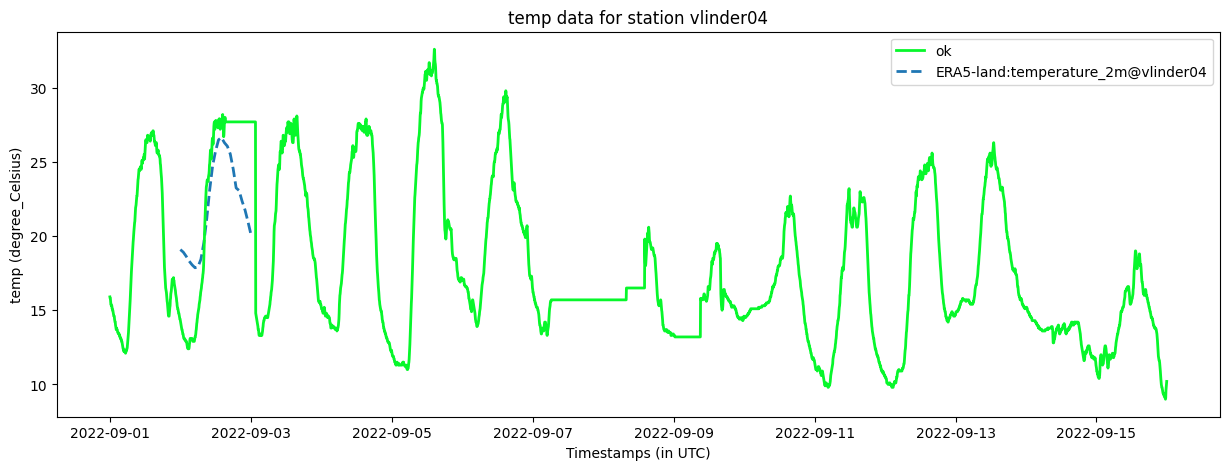

In [19]:
#Plot the modeldata and observational temperatures of a single station
dataset.get_station('vlinder04').make_plot(obstype='temp', show_modeldata=True)

In [20]:
#Interactive spatial plot of the GEE dataset (with the stations as markers)

dataset.make_gee_plot(
    geedatasetmanager=era5_manager,
    timeinstance=pd.Timestamp('2022-09-02 13:00:00'),
    modelobstype='temp',
    vmax=None, #if None, the colorscale is optimalized for the extend of all stations
    vmin=None, #if None, the colorscale is optimalized for the extend of all stations
    )

/home/thoverga/anaconda3/envs/metobs_dev/lib/python3.10/site-packages/metobs_toolkit/geedatasetmanagers.py:968: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = metadf.dissolve().centroid


## Transfer of larger amounts of data 

There is a limit to the amount of data that can be transferred directly from GEE. When the data cannot be transferred directly, **it will be written to a file on your Google Drive**. The location of the file will be printed out. When the writing to the file is done, you must download the file and import it using the ``Dataset.import_gee_data_from_file()`` method.

*Note*: The reason not to check the *read-only* option upon GEE authentication is to enable possibility to write files to your google drive.

As a demonstration we download the temperature and pressure timeseries from ERA5-land, for all the stations and for the same period as the observations (15 days). This amount of data is to large to transfer directly. 

In [21]:

#Extract the timeseries 
_nothing_returned = dataset.get_gee_timeseries_data(
            geedynamicdatasetmanager=era5_manager, #The datasetmanager to use
            startdt_utc=None, #If None, the startdt of the dataset observations is used
            enddt_utc=None, #If None, the startdt of the dataset observations is used
            target_obstypes=['temp', 'pressure'], #the observationtypes to extract, must be knonw modelobstypes
            )


The data request was to big for direct transfer, a (CSV) file is written to your Google Drive (See the link in the printed warning).

Download that file, and then import the modeldata from the file.

In [22]:
%%script true 

#Import the ERA5 data
dataset.import_gee_data_from_file(
        filepath= '... path to the downloaded file ...',
        geedynamicdatasetmanager=era5_manager
        )

# Extending the defaults

The default GeeDatasetManager are illustrative and they may not be sufficient. Here are some demonstrations on how to extend upon the defaults.

### Using a new ModelObstype

In this demo we add the surface sensible heat flux as a new modelobstype and download the timeseries at the location of the stations.

See the [details of the ERA5-land](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_HOURLY) dataset.

,,value,details
datetime,obstype,,
2022-09-01 00:00:00+00:00,sensible_heat_flux,-2671.636963,ERA5-land:surface_sensible_heat_flux converted...
2022-09-01 01:00:00+00:00,sensible_heat_flux,156.804245,ERA5-land:surface_sensible_heat_flux converted...
2022-09-01 02:00:00+00:00,sensible_heat_flux,286.745514,ERA5-land:surface_sensible_heat_flux converted...
2022-09-01 03:00:00+00:00,sensible_heat_flux,417.542999,ERA5-land:surface_sensible_heat_flux converted...
2022-09-01 04:00:00+00:00,sensible_heat_flux,551.778992,ERA5-land:surface_sensible_heat_flux converted...
...,...,...,...
2022-09-15 20:00:00+00:00,sensible_heat_flux,-287.355988,ERA5-land:surface_sensible_heat_flux converted...
2022-09-15 21:00:00+00:00,sensible_heat_flux,-172.500000,ERA5-land:surface_sensible_heat_flux converted...
2022-09-15 22:00:00+00:00,sensible_heat_flux,-58.152000,ERA5-land:surface_sensible_heat_flux converted...


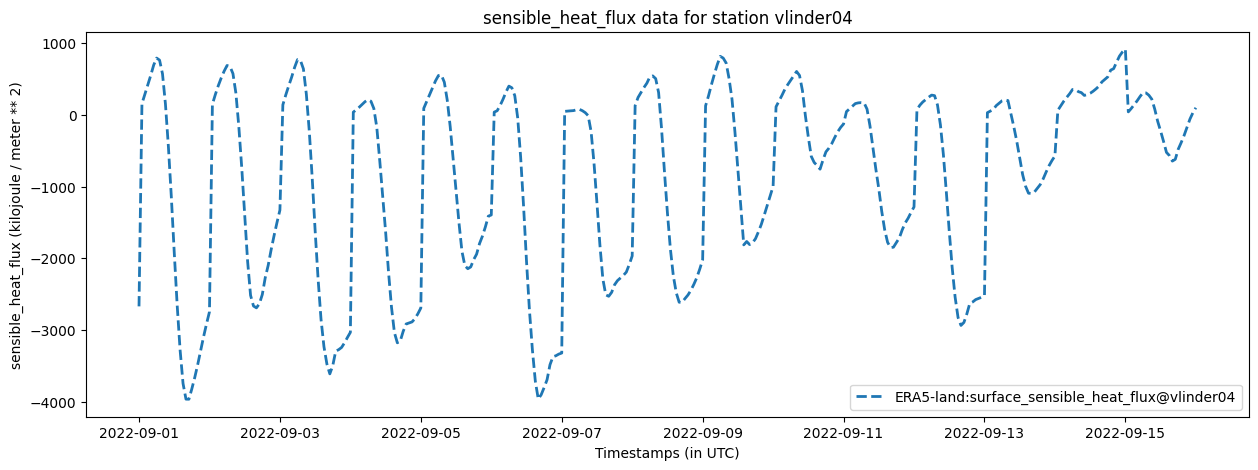

In [23]:
#1. Create a observation type
sensible_heat_flux = metobs_toolkit.Obstype(
                        obsname='sensible_heat_flux',
                        std_unit='kJ/m^2',
                        description='The 2m sensible heat flux.')

#2. Make a ModelObstype
sensible_heat_flux_era5 = metobs_toolkit.ModelObstype(
                            obstype=sensible_heat_flux,
                            model_unit='J/m^2', #see details on GEE
                            model_band='surface_sensible_heat_flux') #see details on GEE

#3. Add the ModelObstype to the dataset manager
era5_manager = metobs_toolkit.default_GEE_datasets['ERA5-land']
era5_manager.add_modelobstype(sensible_heat_flux_era5)


#4. Extract some sensible heat flux data (for a single station as demo)
sens_heat_flx_data = dataset.get_station('vlinder04').get_gee_timeseries_data(
                        geedynamicdatasetmanager=era5_manager,
                        startdt_utc=None,
                        enddt_utc=None,
                        target_obstypes=['sensible_heat_flux'] #refer by obsname
                        )
#The sensible heat flux data is stored as modeldata in the station (if the direct transfer is succescfull!)

#5. make a plot
dataset.get_station('vlinder04').make_plot_of_modeldata(obstype='sensible_heat_flux')

#6. You can also get the data using the modeldatadf attribute
dataset.get_station('vlinder04').modeldatadf


### Defining a new GEE dataset

In this example we create a new ``GeeDyanamicDatasetManager`` that is a JAXA reanalysis product for global precipitation, see [JAXA_GPM_L3_GSMaP_v8_operational](https://developers.google.com/earth-engine/datasets/catalog/JAXA_GPM_L3_GSMaP_v8_operational) details.


value  \
datetime                  obstype                           
2022-09-01 00:00:00+00:00 precip_rate            0.000000   
                          sensible_heat_flux -2671.636963   
2022-09-01 01:00:00+00:00 precip_rate            0.000000   
                          sensible_heat_flux   156.804245   
2022-09-01 02:00:00+00:00 precip_rate            0.000000   
...                                                   ...   
2022-09-15 22:00:00+00:00 sensible_heat_flux   -58.152000   
2022-09-15 23:00:00+00:00 precip_rate            0.000000   
                          sensible_heat_flux    30.048000   
2022-09-16 00:00:00+00:00 precip_rate            0.000000   
                          sensible_heat_flux    99.676003   

                                                                                        details  
datetime                  obstype                                                                
2022-09-01 00:00:00+00:00 precip_rate         JAXA_GPM_reanalysis:hourlyPrecipRate converted...  
                          sensible_heat_flux  ERA5-land:surface_sensible_heat_flux converted...  
2022-09-01 01:00:00+00:00 precip_rate         JAXA_GPM_reanalysis:hourlyPrecipRate converted...  
                          sensible_heat_flux  ERA5-land:surface_sensible_heat_flux converted...  
2022-09-01 02:00:00+00:00 precip_rate         JAXA_GPM_reanalysis:hourlyPrecipRate converted...  
...                                                                                         ...  
2022-09-15 22:00:00+00:00 sensible_heat_flux  ERA5-land:surface_sensible_heat_flux converted...  
2022-09-15 23:00:00+00:00 precip_rate         JAXA_GPM_reanalysis:hourlyPrecipRate converted...  
                          sensible_heat_flux  ERA5-land:surface_sensible_heat_flux converted...  
2022-09-16 00:00:00+00:00 precip_rate         JAXA_GPM_reanalysis:hourlyPrecipRate converted...  
                          sensible_heat_flux  ERA5-land:surface_sensible_heat_flux converted...  

[747 rows x 2 columns]

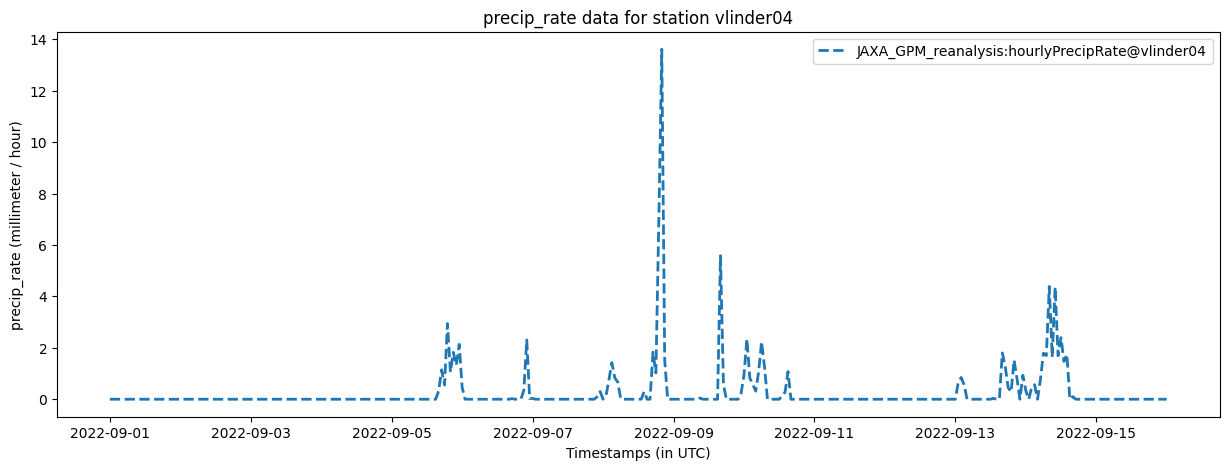

In [24]:
#1. Create an pricipitation observationtype

precip_rate = metobs_toolkit.Obstype(obsname='precip_rate',
                                     std_unit='mm/hour',
                                     description='Rain precipitation rate at surface.')
#2. Create a ModelObstype 
precip_GPM = metobs_toolkit.ModelObstype(
                obstype=precip_rate,
                model_unit='mm/hour', #See GEE dataset details
                model_band='hourlyPrecipRate',#See GEE dataset details
                ) 

#3. Create a ModelDataManager
GPM_v8_manager = metobs_toolkit.GEEDynamicDatasetManager(
    name='JAXA_GPM_reanalysis', 
    location="JAXA/GPM_L3/GSMaP/v8/operational", #See GEE dataset details
    value_type='numeric',
    scale=50,
    time_res='1h',
    modelobstypes=[precip_GPM],
    is_image=False,
    is_mosaic=False,
)

#4. Extract precipitation timeseries data
precip_data = dataset.get_station('vlinder04').get_gee_timeseries_data(
                        geedynamicdatasetmanager=GPM_v8_manager,
                        startdt_utc=None,
                        enddt_utc=None,
                        target_obstypes=['precip_rate'] #refer by obsname
                        )

# 5. make a plot
dataset.get_station('vlinder04').make_plot_of_modeldata(obstype='precip_rate')

# 6. You can also get the data using the modeldatadf attribute
dataset.get_station('vlinder04').modeldatadf

In [25]:
#Or you can make an interactive spatial plot
dataset.make_gee_plot(
        geedatasetmanager=GPM_v8_manager,
        modelobstype='precip_rate',
        timeinstance=pd.Timestamp('2022-09-08 16:00:00'))


/home/thoverga/anaconda3/envs/metobs_dev/lib/python3.10/site-packages/metobs_toolkit/geedatasetmanagers.py:968: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # centroid = metadf.dissolve().centroid
